In [1]:
from os import listdir
from os.path import isfile, join
import json
import os
import time
import matplotlib.pyplot as plt 
import pandas as pd
import subprocess

import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import numpy as np
import tqdm
from PIL import Image
import pickle

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from copy import deepcopy
from collections import OrderedDict

In [2]:
%matplotlib inline

In [3]:
project_path = '' #'drive/My Drive/InstaDump'

train_jsons = join(project_path, "small_train_jsons")
val_jsons = join(project_path, "small_val_jsons")
photos_for_train = join(project_path, 'photos_for_train')

models_path = join(project_path, 'models_path')

photos_for_train

'photos_for_train'

In [4]:
checked_username = [a[:-5] for a in listdir(train_jsons)]
checked_username[:3], len(checked_username)

(['n0v1_74n', 'vibrationoflight', 'liliannastina'], 762)

In [5]:
with open(join(project_path, "tag2idx_small.json"), 'r') as f:
    tag2idx = json.loads(f.read()) 

idx2tag = {}

for k, v in tag2idx.items():
    idx2tag[v] = k

len(tag2idx.keys())

152

In [6]:
idx2tag = {}

for t, i in tag2idx.items():
    idx2tag[i] = t

In [7]:
local_path = photos_for_train

In [8]:
import torch
from torch.utils.data import Dataset as TorchDataset

class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, tags, photos_dir_list, transform = None, main_photo_dir = local_path, n_tags = 152):
        self.tags = tags
        self.photos_dir_list = photos_dir_list
        self.main_photo_dir = main_photo_dir
        self.transform = transform
        self.n_tags = n_tags

    def __getitem__(self, idx):
        # loading image by its path
        img = Image.open(join(self.main_photo_dir, self.photos_dir_list[idx]))
        img = img.convert('RGB')
        # applying transformation
        if self.transform is not None:
            img = self.transform(img)
        img = img.numpy()

        # label = torch.from_numpy(self.y[idx])
        label = np.zeros(self.n_tags)
        label[self.tags[idx]] = 1.
        
        # returning image and its class
        return img.astype('float32'), label
        # return img, label

    def __len__(self):
        return len(self.photos_dir_list)

In [9]:
saved_users_part1 = deepcopy(checked_username)[:300]
saved_users_part2 = deepcopy(checked_username)[300:600]
saved_users_part3 = deepcopy(checked_username)[600:]

len(saved_users_part1), len(saved_users_part2), len(saved_users_part3)

(300, 300, 162)

In [10]:
# preparation

batch_size_for_all = 128

means = np.array([0.485, 0.456, 0.406])
stds = np.array([0.229, 0.224, 0.225])

input_size = 299

# data transformations    
data_transform = transforms.Compose([
    transforms.RandomRotation([-15, 15]),
    transforms.ColorJitter(),
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((input_size,input_size)),
    # transforms.RandomResizedCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

val_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    # transforms.Resize(input_size),
    # transforms.Scale(input_size),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        new_tensor = deepcopy(tensor)
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [11]:
%%time
# train
name = saved_users_part1[1]

with open(f'{train_jsons}/{name}.json', 'r') as f:
    username_json = json.loads(f.read())

train_user_dataset_1 = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = data_transform)

for name in tqdm.tqdm(saved_users_part1[2:]):

    with open(f'{train_jsons}/{name}.json', 'r') as f:
        username_json = json.loads(f.read())

    new_user_dataset = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = data_transform)


    train_user_dataset_1 = ConcatDataset([new_user_dataset, train_user_dataset_1])

# valid
name = saved_users_part1[1]

with open(f'{val_jsons}/{name}.json', 'r') as f:
    username_json = json.loads(f.read())

val_user_dataset_1 = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = val_transform)

for name in tqdm.tqdm(saved_users_part1[2:]):

    with open(f'{val_jsons}/{name}.json', 'r') as f:
        username_json = json.loads(f.read())

    new_user_dataset = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = val_transform)


    val_user_dataset_1 = ConcatDataset([new_user_dataset, val_user_dataset_1])


train_loader_1 = DataLoader(train_user_dataset_1, batch_size = batch_size_for_all,  num_workers=32, shuffle=True) 
val_loader_1 = DataLoader(val_user_dataset_1, batch_size = batch_size_for_all,  num_workers=32, shuffle=True) 

100%|██████████| 298/298 [00:00<00:00, 14632.43it/s]

CPU times: user 150 ms, sys: 16.2 ms, total: 166 ms
Wall time: 165 ms


In [12]:
%%time
# train
name = saved_users_part2[1]

with open(f'{train_jsons}/{name}.json', 'r') as f:
    username_json = json.loads(f.read())

train_user_dataset_2 = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = data_transform)

for name in tqdm.tqdm(saved_users_part2[2:]):

    with open(f'{train_jsons}/{name}.json', 'r') as f:
        username_json = json.loads(f.read())

    new_user_dataset = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = data_transform)


    train_user_dataset_2 = ConcatDataset([new_user_dataset, train_user_dataset_2])

# valid
name = saved_users_part2[1]

with open(f'{val_jsons}/{name}.json', 'r') as f:
    username_json = json.loads(f.read())

val_user_dataset_2 = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = val_transform)

for name in tqdm.tqdm(saved_users_part2[2:]):

    with open(f'{val_jsons}/{name}.json', 'r') as f:
        username_json = json.loads(f.read())

    new_user_dataset = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = val_transform)


    val_user_dataset_2 = ConcatDataset([new_user_dataset, val_user_dataset_2])


train_loader_2 = DataLoader(train_user_dataset_2, batch_size = batch_size_for_all,  num_workers=32, shuffle=True) 
val_loader_2 = DataLoader(val_user_dataset_2, batch_size = batch_size_for_all,  num_workers=32, shuffle=True) 

100%|██████████| 298/298 [00:00<00:00, 14150.05it/s]


CPU times: user 151 ms, sys: 27.9 ms, total: 179 ms
Wall time: 177 ms


In [13]:
%%time
# train
name = saved_users_part3[1]

with open(f'{train_jsons}/{name}.json', 'r') as f:
    username_json = json.loads(f.read())

train_user_dataset_3 = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = data_transform)

for name in tqdm.tqdm(saved_users_part3[2:]):

    with open(f'{train_jsons}/{name}.json', 'r') as f:
        username_json = json.loads(f.read())

    new_user_dataset = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = data_transform)


    train_user_dataset_3 = ConcatDataset([new_user_dataset, train_user_dataset_3])

# valid
name = saved_users_part3[1]

with open(f'{val_jsons}/{name}.json', 'r') as f:
    username_json = json.loads(f.read())

val_user_dataset_3 = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = val_transform)

for name in tqdm.tqdm(saved_users_part3[2:]):

    with open(f'{val_jsons}/{name}.json', 'r') as f:
        username_json = json.loads(f.read())

    new_user_dataset = Dataset(username_json['tags'], username_json['photo_file_path'], 
                       main_photo_dir = local_path, transform = val_transform)


    val_user_dataset_3 = ConcatDataset([new_user_dataset, val_user_dataset_3])


train_loader_3 = DataLoader(train_user_dataset_3, batch_size = batch_size_for_all,  num_workers=32, shuffle=True) 
val_loader_3 = DataLoader(val_user_dataset_3, batch_size = batch_size_for_all,  num_workers=32, shuffle=True) 

100%|██████████| 160/160 [00:00<00:00, 13574.07it/s]

CPU times: user 134 ms, sys: 7.69 ms, total: 142 ms
Wall time: 141 ms


In [14]:
train_user_dataset = ConcatDataset([train_user_dataset_1, train_user_dataset_2])
train_user_dataset = ConcatDataset([train_user_dataset, train_user_dataset_3])
val_user_dataset = ConcatDataset([val_user_dataset_1, val_user_dataset_2])
val_user_dataset = ConcatDataset([val_user_dataset, val_user_dataset_3])


train_loader = DataLoader(train_user_dataset, batch_size = batch_size_for_all,  num_workers=32, shuffle=True) 
val_loader = DataLoader(val_user_dataset, batch_size = batch_size_for_all,  num_workers=32, shuffle=True) 

In [15]:
# just a function for visualization
def draw_samples(samples, labels, n = 8):
    counter = 1
    cols = 8
    rows = n/cols
    plt.figure(figsize=(12,rows*2))

    for lab, sample in zip(labels,samples):

        plt.subplot(rows,cols,counter)

        # title = ' '.join(lab)
        # plt.title(title)
        # plt.title(lab)
        s = deepcopy(sample)
        s = unorm(s)
        
        image_to_plot = np.clip(np.transpose(s.cpu().detach().numpy(),[1,2,0]), 0.,1.) 
        
        fig= plt.imshow(image_to_plot)
        
#         fig= plt.imshow(np.transpose(sample,[1,2,0]))
        fig.axes.get_xaxis().set_visible(False) # for removing axis
        fig.axes.get_yaxis().set_visible(False) # for removing axis
        
        counter +=1
        if counter > n:
            plt.show()
            break

labels.shape: torch.Size([128, 152])
samples.shape: torch.Size([128, 3, 299, 299])


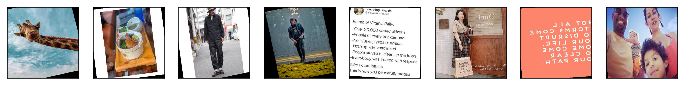

labels.shape: torch.Size([128, 152])
samples.shape: torch.Size([128, 3, 299, 299])


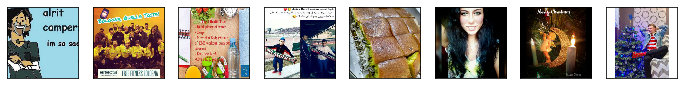

In [16]:
for loader in [train_loader, val_loader]:
    
    samples, labels = iter(loader).next()

    print(f"labels.shape: {labels.shape}")
    print(f"samples.shape: {samples.shape}")

    draw_samples(samples, labels)

In [17]:
%%time
from torchvision.models.inception import inception_v3

model_inception = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

CPU times: user 5min 38s, sys: 7.85 s, total: 5min 46s
Wall time: 3min 18s


In [18]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [19]:
model = deepcopy(model_inception)
model.aux_logits = False

num_classes = 152 # Number of classes in the dataset

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

model.aux_logits = False
# model.AuxLogits.fc = nn.Linear(768, num_classes)

inner_layer_neurons = 512

model.fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(num_ftrs, inner_layer_neurons)),
    ('bn1', nn.BatchNorm1d(num_features=inner_layer_neurons)),
    ('relu', nn.LeakyReLU()),
    ('fc2', nn.Linear(inner_layer_neurons,num_classes)),
]))

model = model.to(device=device)

params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.fc1.weight
	 fc.fc1.bias
	 fc.bn1.weight
	 fc.bn1.bias
	 fc.fc2.weight
	 fc.fc2.bias


In [20]:
%%time
samples, labels = iter(val_loader).next()

print(f"labels.shape: {labels.shape}")
print(f"samples.shape: {samples.shape}")

samples_to_pred = deepcopy(samples)
samples_to_plot = unorm(deepcopy(samples_to_pred))

samples_to_pred = samples_to_pred.to(device=device)  # move to device, e.g. GPU

labels.shape: torch.Size([128, 152])
samples.shape: torch.Size([128, 3, 299, 299])
CPU times: user 529 ms, sys: 1.32 s, total: 1.85 s
Wall time: 4.46 s


In [21]:
labels[0].shape

torch.Size([152])

In [22]:
def show_preds_with_images(model, samples_to_pred=samples_to_pred, 
                           samples_to_plot=samples_to_plot,labels=labels):
    model.eval()
    output = model(samples_to_pred)
    
    counter = 1
    cols = 4
    rows = 2
    plt.figure(figsize=(24,rows*5.5))
    
    k = 5

    for photo_ind in range(8):
        labs = labels.cpu().detach().numpy()[photo_ind] 
        true_labels = np.arange(len(labs))[labs == 1] 

        top_5 = np.argsort(output.cpu().detach().numpy()[photo_ind])[:-6:-1]
        intersection = min(k, len(set(top_5) & set(true_labels)))

        precision_k = intersection / k
        recall_k = intersection / len(true_labels)

        plt.subplot(rows,cols,counter)
    
        image_to_plot = np.clip(np.transpose(samples_to_plot.cpu().detach().numpy()[photo_ind],[1,2,0]), 0.,1.) 
    
        fig= plt.imshow(image_to_plot)
        
        title = "True: "+', '.join([idx2tag[ind] for ind in true_labels]) + '\n'+\
                "Top5: "+', '.join([idx2tag[ind] for ind in top_5])+'\n' +\
                f'Precision@k= {round(precision_k, 4)}, Recall@k= {round(recall_k, 4)}'
        plt.title(title)
        fig.axes.get_xaxis().set_visible(False) # for removing axis
        fig.axes.get_yaxis().set_visible(False)
        
        counter +=1
        
    plt.show()

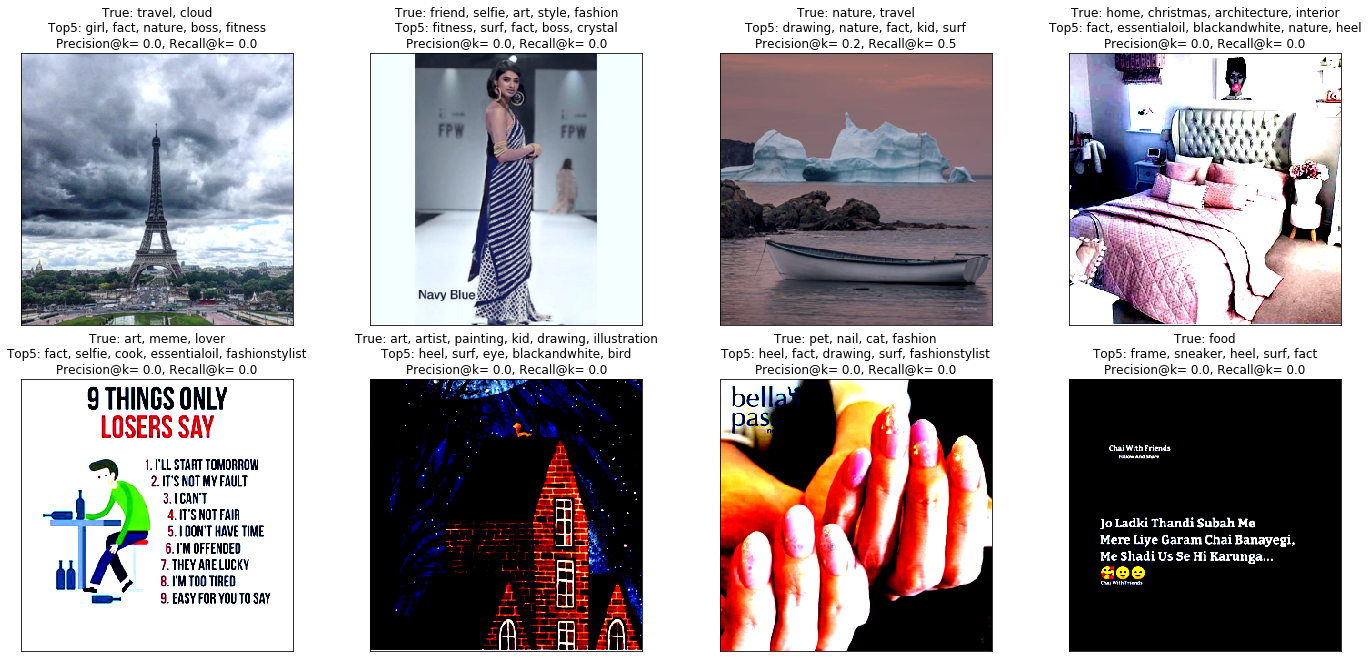

In [23]:
show_preds_with_images(model)

In [24]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

from torch.optim.lr_scheduler import StepLR

# gamma = decaying factor
scheduler = StepLR(optimizer, step_size=2, gamma=0.05)

 ------------------------------------------------------------- 
Epoch: 0

	Train Loss: 0.0739(std:0.0221), 	precision: 0.5243(std:0.3536), 	recall: 0.4964(std:0.3475)
	Val Loss: 0.0686(std:0.0038), 	precision: 0.6084(std:0.3662), 	recall: 0.5715(std:0.3604)
	Took time: 1106.56


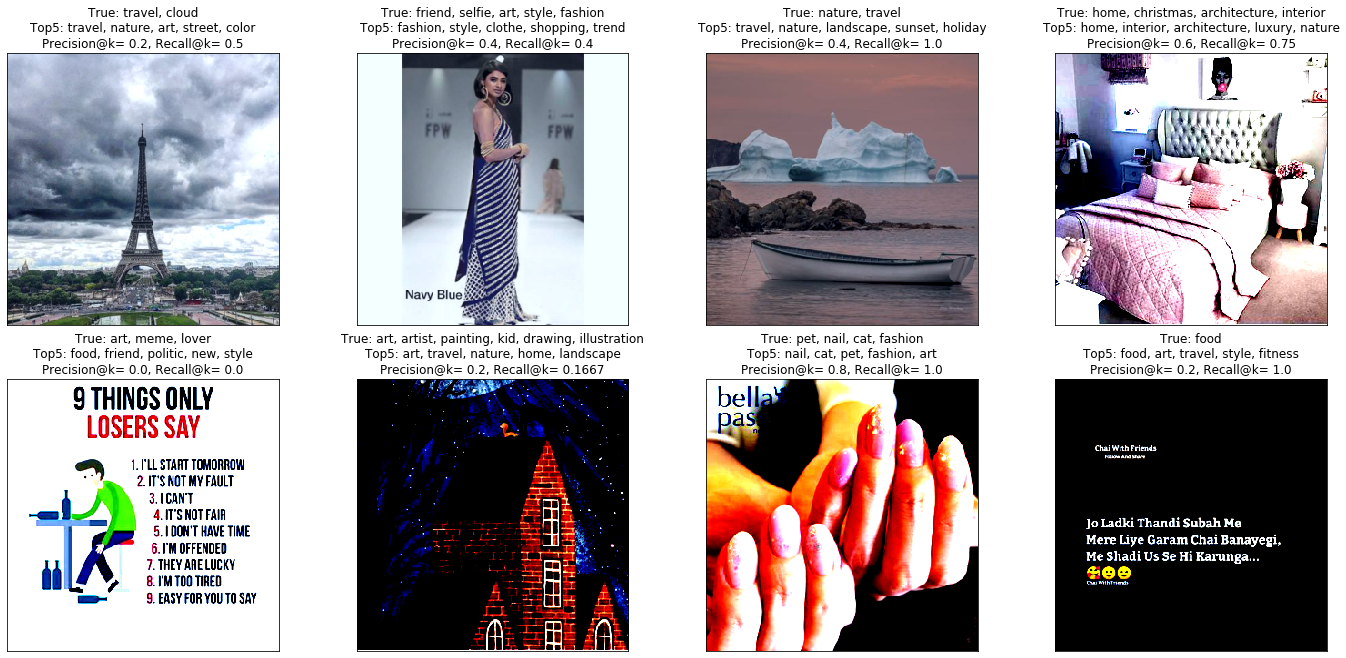

 
 ------------------------------------------------------------- 
Epoch: 1

	Train Loss: 0.0683(std:0.0040), 	precision: 0.5607(std:0.3566), 	recall: 0.5309(std:0.3512)
	Val Loss: 0.0675(std:0.0034), 	precision: 0.6517(std:0.3571), 	recall: 0.6207(std:0.3535)
	Took time: 1118.52


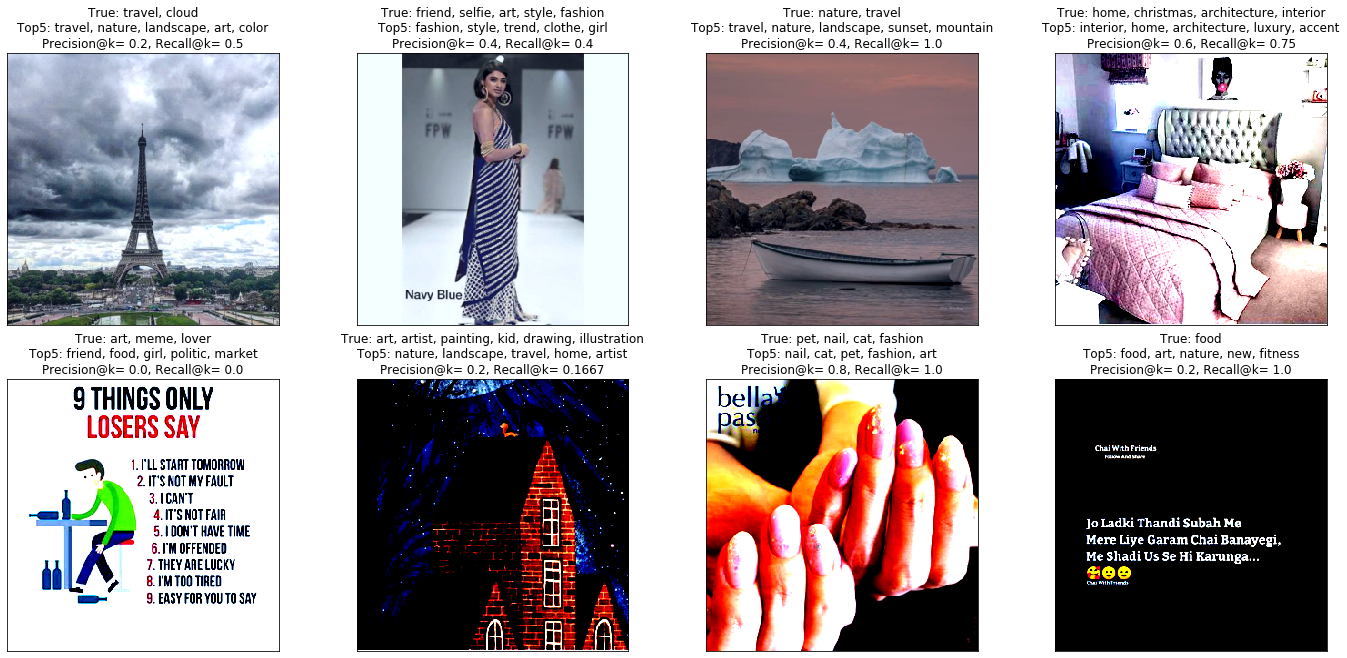

 
 ------------------------------------------------------------- 
Epoch: 2

	Train Loss: 0.0660(std:0.0039), 	precision: 0.5781(std:0.3620), 	recall: 0.5502(std:0.3564)
	Val Loss: 0.0659(std:0.0033), 	precision: 0.5922(std:0.3754), 	recall: 0.5697(std:0.3740)
	Took time: 1118.48


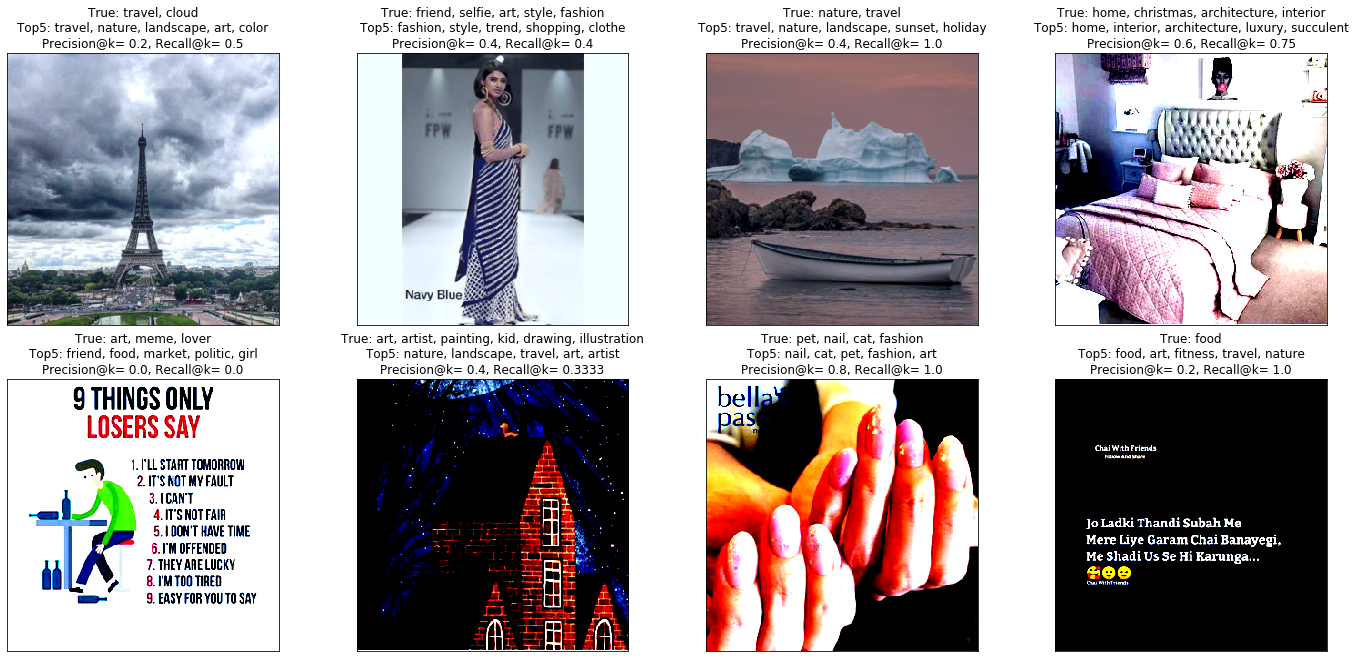

 
 ------------------------------------------------------------- 
Epoch: 3

	Train Loss: 0.0654(std:0.0040), 	precision: 0.5869(std:0.3587), 	recall: 0.5588(std:0.3554)
	Val Loss: 0.0655(std:0.0034), 	precision: 0.5855(std:0.3590), 	recall: 0.5511(std:0.3542)
	Took time: 1118.86


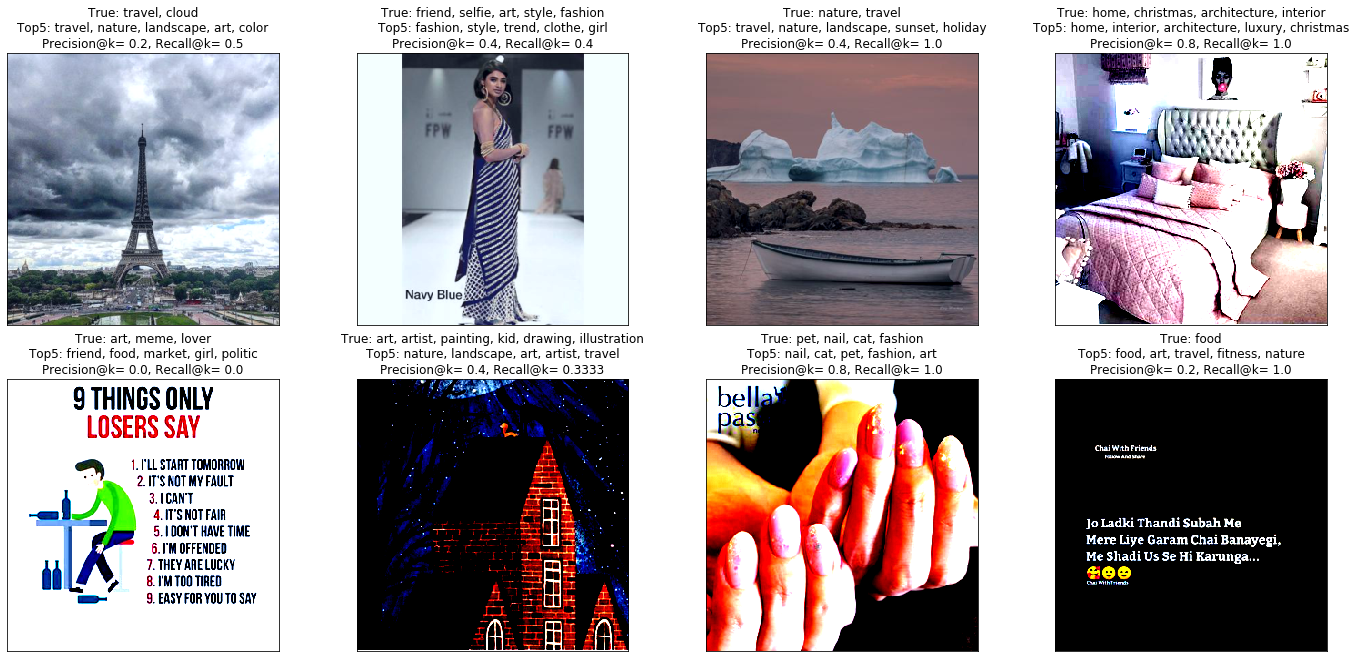

 
 ------------------------------------------------------------- 
Epoch: 4

	Train Loss: 0.0651(std:0.0039), 	precision: 0.5807(std:0.3641), 	recall: 0.5485(std:0.3566)
	Val Loss: 0.0655(std:0.0035), 	precision: 0.6065(std:0.3402), 	recall: 0.5735(std:0.3355)
	Took time: 1116.41


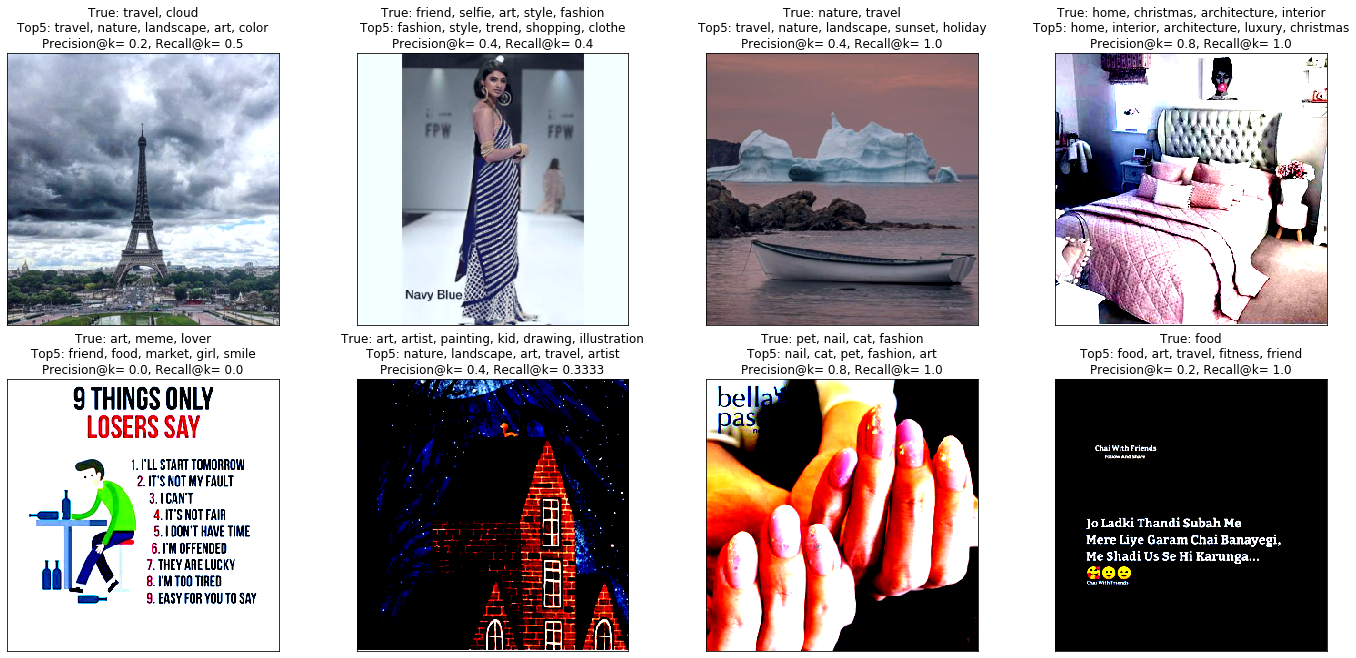

 
 ------------------------------------------------------------- 
Epoch: 5

	Train Loss: 0.0651(std:0.0038), 	precision: 0.6014(std:0.3586), 	recall: 0.5708(std:0.3542)
	Val Loss: 0.0657(std:0.0034), 	precision: 0.6608(std:0.3410), 	recall: 0.6210(std:0.3350)
	Took time: 1114.18


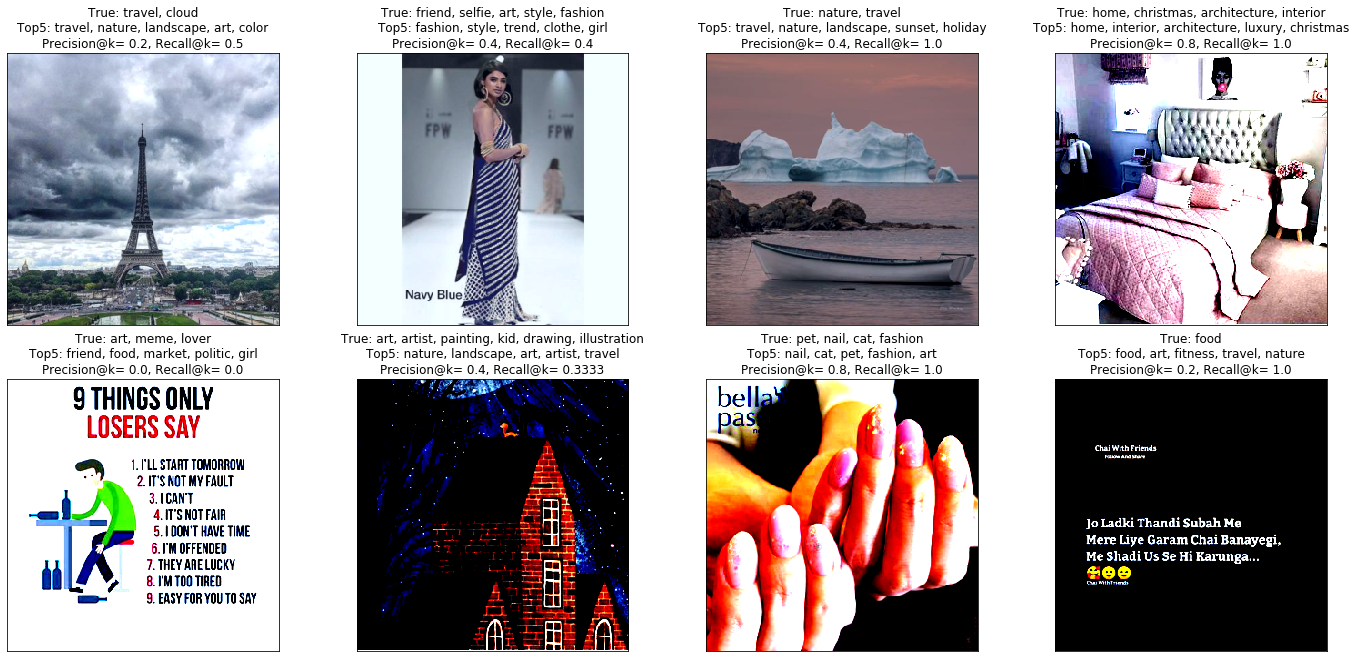

 
 ------------------------------------------------------------- 
Epoch: 6

	Train Loss: 0.0651(std:0.0038), 	precision: 0.5818(std:0.3498), 	recall: 0.5499(std:0.3436)
	Val Loss: 0.0655(std:0.0034), 	precision: 0.6133(std:0.3630), 	recall: 0.5825(std:0.3549)
	Took time: 1116.51


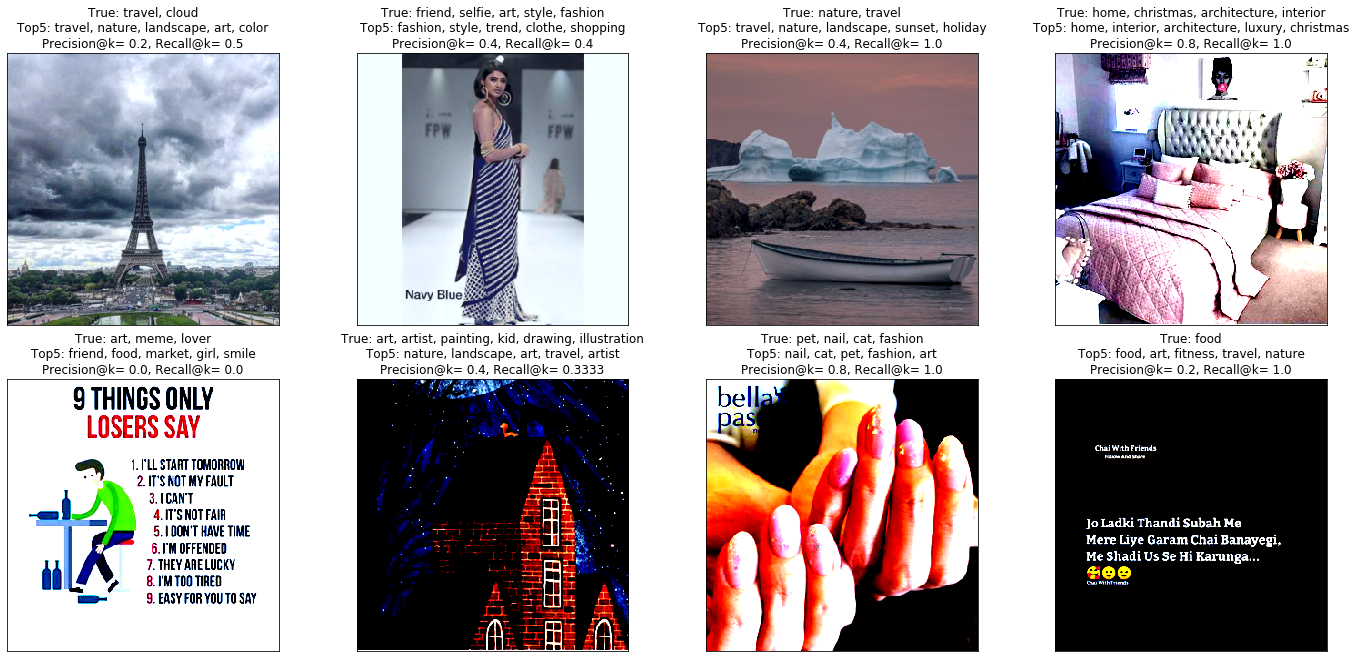

 
 ------------------------------------------------------------- 
Epoch: 7

	Train Loss: 0.0651(std:0.0038), 	precision: 0.5821(std:0.3565), 	recall: 0.5532(std:0.3518)
	Val Loss: 0.0655(std:0.0032), 	precision: 0.6062(std:0.3703), 	recall: 0.5962(std:0.3688)
	Took time: 1095.96


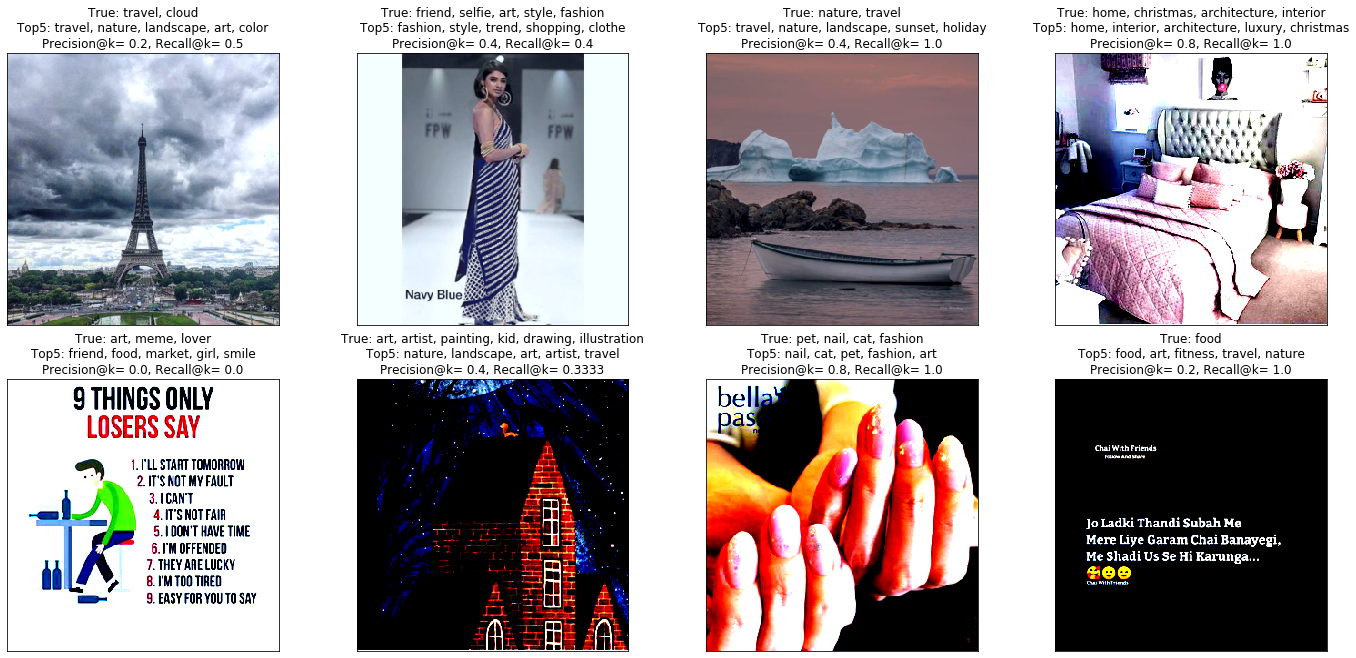

 
 ------------------------------------------------------------- 
Epoch: 8


In [ ]:
model_name = 'inception_4'

train_loss_list = []
train_precision_k_list = []
train_recall_k_list = []

val_loss_list = []
val_precision_k_list = []
val_recall_k_list = []

k = 5

for epoch in range(50):
    print(' ------------------------------------------------------------- ')
    print(f'Epoch: {epoch}')
    start_time = time.time()
    model.train()
    inner_train_loss_list = []
    inner_precision_k_list = []
    inner_recall_k_list = []

    for X, y in train_loader:
        
        X = X.to(device=device)  # move to device, e.g. GPU
        y = y.to(device=device)

        optimizer.zero_grad()

        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        inner_train_loss_list.append(loss.item())


        labels = y.cpu().detach().numpy()[0] 
        true_labels = np.arange(len(labels))[labels == 1]
        n_true = len(true_labels)

        top_5 = np.argsort(output.cpu().detach().numpy()[0])[:-6:-1]
        intersection = min(k, len(set(top_5) & set(true_labels)))

        precision_k = intersection / min(k, n_true)
        recall_k = intersection / n_true

        inner_precision_k_list.append(precision_k)
        inner_recall_k_list.append(recall_k)

    train_loss_mean = np.mean(inner_train_loss_list)
    precision_mean = np.mean(inner_precision_k_list)
    recall_mean = np.mean(inner_recall_k_list)

    train_loss_std = np.std(inner_train_loss_list)
    precision_std = np.std(inner_precision_k_list)
    recall_std = np.std(inner_recall_k_list)
    
    print('\n\tTrain Loss: {:.4f}(std:{:.4f}), \tprecision: {:.4f}(std:{:.4f}), \trecall: {:.4f}(std:{:.4f})'.format(train_loss_mean, train_loss_std,
                                                                                                                   precision_mean, precision_std,
                                                                                                                   recall_mean, recall_std))
    train_loss_list.append(train_loss_mean)
    train_precision_k_list.append(precision_mean)
    train_recall_k_list.append(recall_mean)
    train_time = time.time()

    scheduler.step()
    
    # validation
    model.eval()
    inner_val_loss_list = []
    inner_precision_k_list = []
    inner_recall_k_list = []

    for X, y in val_loader:
        X = X.to(device=device)  # move to device, e.g. GPU
        y = y.to(device=device)

        output = model(X)
        loss = criterion(output, y)
    
        inner_val_loss_list.append(loss.item())

        labels = y.cpu().detach().numpy()[0] 
        true_labels = np.arange(len(labels))[labels == 1]

        top_5 = np.argsort(output.cpu().detach().numpy()[0])[:-6:-1]
        intersection = min(k, len(set(top_5) & set(true_labels)))
        n_true = len(true_labels)

        precision_k = intersection / min(k, n_true)
        recall_k = intersection / n_true

        inner_precision_k_list.append(precision_k)
        inner_recall_k_list.append(recall_k)

    val_loss_mean = np.mean(inner_val_loss_list)
    precision_mean = np.mean(inner_precision_k_list)
    recall_mean = np.mean(inner_recall_k_list)

    val_loss_std = np.std(inner_val_loss_list)
    precision_std = np.std(inner_precision_k_list)
    recall_std = np.std(inner_recall_k_list)

    val_loss_mean = np.mean(inner_val_loss_list)
    print('\tVal Loss: {:.4f}(std:{:.4f}), \tprecision: {:.4f}(std:{:.4f}), \trecall: {:.4f}(std:{:.4f})'.format(val_loss_mean, val_loss_std, 
                                                                                                                 precision_mean, precision_std,
                                                                                                                 recall_mean, recall_std))
    # print('\tVal Loss: {:.4f}'.format(train_loss_mean))
    val_precision_k_list.append(precision_mean)
    val_recall_k_list.append(recall_mean)
    val_loss_list.append(val_loss_mean)
    
#     if (recall_mean >= 0.5) | (precision_mean >= 0.5):
    torch.save(model, join(models_path, f"{model_name}_{epoch}epoch_{round(precision_mean,4)}prec_{round(recall_mean,4)}rec"))

    print('\tTook time: {:.2f}'.format(time.time() - start_time))
    show_preds_with_images(model)
    print(' ')